In [1]:
import pandas as pd
import datetime 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os 
from datetime import datetime
import time

In [2]:
from plot_functions import plot_results
from plot_functions import plot_results_by_month
from helpers import day_ahead_forecast
from helpers import prepare_tcn_features

## Pipeline

1. Data Preparation:
   - Load and preprocess data.
   - Create lagged features for power consumption and align them with the forecasted temperature data for the next 24 hours.
   - Split data into train, validation, and test sets
2. Model Definition:
   - Use the TCN architecture, which employs causal convolutions to ensure predictions only depend on past data.
3. Training:
   - Define a loss function and optimizer.
   - Train the model using the training set, and monitor validation loss to prevent overfitting.
8. Evaluation:
   - Predict the next 24 hours on the test set.
   - Compare TCN predictions with SARIMA using evaluation metrics like RMSE, MAE, and MAPE.

In [4]:
# Save current directory
current_directory = os.getcwd()

# Set print options to suppress scientific notation and show 3 decimal places
np.set_printoptions(suppress=True, precision=5)
pd.options.display.float_format = '{:.5f}'.format

# Suppress all warnings globally
import warnings
warnings.filterwarnings("ignore")

In [5]:
file_path = os.path.join(current_directory, 'data_augmented/X_small.csv')
X_small = pd.read_csv(file_path, index_col = 0)

file_path = os.path.join(current_directory, 'data_augmented/timestamps.csv')
timestamps = pd.read_csv(file_path, index_col = 0)

file_path = os.path.join(current_directory, 'data_augmented/temperature.csv')
temperature = pd.read_csv(file_path, index_col = 0)

In [6]:
df = X_small 

In [7]:
df['timestamp'] = timestamps
df.set_index("timestamp", inplace=True)

df.index = pd.to_datetime(df.index)
df = df.asfreq('H')  # 'H' for hourly frequency

In [8]:
df

,power_consumption,ghi,temp,wind,is_weekend,is_spring,is_summer,is_autumn,is_winter,is_holiday,is_daylight
timestamp,,,,,,,,,,,
2022-04-13 10:00:00+00:00,0.21837,2.31866,0.44842,-0.83739,0,1,0,0,0,0,1
2022-04-13 11:00:00+00:00,-0.11143,2.09107,0.56725,-0.36810,0,1,0,0,0,0,1
2022-04-13 12:00:00+00:00,-0.16639,1.98543,0.69246,0.11499,0,1,0,0,0,0,1
2022-04-13 13:00:00+00:00,-0.03585,1.27027,0.76656,0.01837,0,1,0,0,0,0,1
2022-04-13 14:00:00+00:00,0.30769,1.71318,0.79978,-0.17487,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
2024-06-17 01:00:00+00:00,-1.06418,-0.65983,-0.05753,-0.23008,0,0,1,0,0,0,0
2024-06-17 02:00:00+00:00,-1.05848,-0.65983,-0.09075,-0.21628,0,0,1,0,0,0,0
2024-06-17 03:00:00+00:00,-1.02523,-0.65983,-0.07669,-0.25768,0,0,1,0,0,0,0


In [9]:
target_col = "power_consumption"
exog_cols = ['temp'] # [col for col in df.columns if col not in target_col]
window_length = 168  # 7 days
forecast_horizon = 24  # Next 24 hours

In [10]:
# Step 1: Train-Test Split
train_size = int(len(df) * 0.95)  # Determine initial train size based on 80%
initial_test_start = train_size  

while df.index[initial_test_start].hour != 11: # Adjust test start to align with the next occurrence of 11 AM
    initial_test_start += 1

final_test_end = len(df) - 1
while df.index[final_test_end].hour != 10: # Adjust test end to align with the last 10 AM in the dataset
    final_test_end -= 1

train = df.iloc[:initial_test_start]
test = df.iloc[initial_test_start:final_test_end+1]  # Include the last index

In [11]:
X, y, timestamps = prepare_tcn_features(df, target_col, exog_cols, window_length, forecast_horizon, include_forecast=True)
X_train, y_train, timestamps_train = prepare_tcn_features(train, target_col, exog_cols, window_length, forecast_horizon, include_forecast=True)
X_test, y_test, timestamps_test = prepare_tcn_features(test, target_col, exog_cols, window_length, forecast_horizon, include_forecast=True)

In [12]:
X_train.shape

(17954, 168, 35)

In [13]:
file_path = os.path.join(current_directory, 'data_augmented/X_train.npy')
np.save(file_path, X_train)
file_path = os.path.join(current_directory, 'data_augmented/y_train.npy')
np.save(file_path, y_train)
file_path = os.path.join(current_directory, 'data_augmented/timestamps_train.csv')
timestamps_train.to_series().to_csv(file_path, index=False) 
file_path = os.path.join(current_directory, 'data_augmented/X_test.npy')
np.save(file_path, X_test)
file_path = os.path.join(current_directory, 'data_augmented/y_test.npy')
np.save(file_path, y_test)
file_path = os.path.join(current_directory, 'data_augmented/timestamps_test.csv')
timestamps_test.to_series().to_csv(file_path, index=False) 

In [14]:
import torch
import torch.nn as nn

class TemporalConvNet(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size=3, dropout=0.2):
        """
        Temporal Convolutional Network for Power Consumption Forecasting.

        Parameters:
            input_size (int): Number of input features.
            output_size (int): Number of output features (forecast horizon).
            num_channels (list): Number of channels in each TCN layer.
            kernel_size (int): Size of the convolution kernel.
            dropout (float): Dropout rate.
        """
        super(TemporalConvNet, self).__init__()
        layers = []
        for i in range(len(num_channels)):
            in_channels = input_size if i == 0 else num_channels[i - 1]
            out_channels = num_channels[i]
            layers += [
                nn.Conv1d(in_channels, out_channels, kernel_size, stride=1, padding=(kernel_size - 1)),
                nn.ReLU(),
                nn.Dropout(dropout)
            ]
        self.network = nn.Sequential(*layers)
        self.linear = nn.Linear(num_channels[-1], output_size)

    def forward(self, x):
        """
        Forward pass of the TCN.

        Input:
            x: Shape (batch_size, seq_length, input_size).
        Output:
            y: Shape (batch_size, output_size).
        """
        x = x.permute(0, 2, 1)  # Change to (batch_size, input_size, seq_length)
        x = self.network(x)
        x = x[:, :, -1]  # Take the last time step
        x = self.linear(x)
        return x


In [15]:
# Check if MPS (Metal Performance Shaders) is available
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use the MPS device for Apple Silicon
elif torch.cuda.is_available():
    device = torch.device("cuda")  # Use CUDA if available
else:
    device = torch.device("cpu")  # Default to CPU if no GPU backend is available

print(f"Using device: {device}")

Using device: cpu


**Dropout**
Dropout randomly disables a fraction of neurons during training to reduce reliance on specific neurons, promoting generalization.
Increase the dropout rate (e.g., 0.3 or 0.5) to enforce stronger regularization.
**Stride**
Stride controls how much the convolution kernel moves along the sequence. A larger stride reduces the number of computations and introduces a form of downsampling.
Increasing the stride (e.g., stride = 2) reduces the model's capacity by aggregating features more aggressively. This may help with overfitting but can also lose fine-grained temporal information.
**Number of hidden channels**
Determines the number of filters in each TCN layer, controlling model capacity.
Reduce the number of channels (e.g., $[32, 64, 32]$) to decrease the model's capacity and reduce the risk of overfitting.
**Kernel**
Determines the size of the convolutional filter. Larger kernels allow the model to capture broader temporal patterns but increase complexity.
Keep it small (3 or 5) to limit capacity and focus on short-term temporal dependencies.
**Weight regularization** 
Add L1 or L2 regularization to the optimizer to penalize large weights.
**Batch size**
Use larger batch sizes to improve the robustness of gradient updates.
**Early Stopping**
Monitor validation loss and stop training when it stops improving to prevent overfitting to the training set.
**Learning rate**
Use a smaller learning rate to make more refined updates to the weights.

In [17]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for batching
from torch.utils.data import DataLoader, TensorDataset

batch_size = 256
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize the TCN model
input_size = X.shape[2]  # Number of features per time step
output_size = y.shape[1]  # Forecast horizon (24 hours)
hidden_channels = [32, 64, 32] # [64, 128, 64]  # Number of channels in hidden layers
dropout_rate = 0.3
kernel_size = 3

model = TemporalConvNet(input_size, output_size, hidden_channels, kernel_size=kernel_size, dropout=dropout_rate).to(device)

# Training setup
learning_rate = 1e-3
weight_decay = 1e-4  # L2 regularization
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.MSELoss()

# Early stopping parameters
patience_limit = 5
best_val_loss = float("inf")
patience_counter = 0

# Training loop with early stopping
num_epochs = 50  # Increased epochs to allow for early stopping
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    epoch_loss = 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Print training metrics
    epoch_loss /= len(train_loader)
    end_time = time.time()
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, Time: {end_time - start_time:.2f} seconds")

    # Early stopping logic
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_test_tensor.to(device))
        val_loss = criterion(val_predictions, y_test_tensor.to(device)).item()

    print(f"Validation Loss: {val_loss:.4f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Optionally, save the best model
        torch.save(model.state_dict(), "best_tcn_model.pth")
        # Save the model and X_test_tensor
        torch.save({
            'model_state_dict': model.state_dict(),
            'input_size': input_size,
            'output_size': output_size,
            'hidden_channels': hidden_channels,
            'kernel_size': kernel_size,
            'dropout': dropout_rate,
            'X_train_tensor': X_train_tensor.cpu(),
            'X_test_tensor': X_test_tensor.cpu(),
            'y_train_tensor': y_train_tensor.cpu(),
            'y_test_tensor': y_test_tensor.cpu(),
            'batch_size': batch_size 
        }, "best_tcn_model_and_data.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience_limit:
            print("Early stopping triggered.")
            break

# Test the model
model.load_state_dict(torch.load("best_tcn_model.pth"))  # Load the best model
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor.to(device))
    test_loss = criterion(test_predictions, y_test_tensor.to(device)).item()
print(f"Test Loss: {test_loss:.4f}")

Epoch 1, Loss: 0.8162, Time: 19.79 seconds
Validation Loss: 0.4913
Epoch 2, Loss: 0.5598, Time: 20.54 seconds
Validation Loss: 0.4302
Epoch 3, Loss: 0.5179, Time: 19.64 seconds
Validation Loss: 0.4051
Epoch 4, Loss: 0.4926, Time: 19.78 seconds
Validation Loss: 0.3792
Epoch 5, Loss: 0.4746, Time: 20.26 seconds
Validation Loss: 0.3746
Epoch 6, Loss: 0.4645, Time: 19.67 seconds
Validation Loss: 0.3699
Epoch 7, Loss: 0.4578, Time: 20.80 seconds
Validation Loss: 0.3669
Epoch 8, Loss: 0.4494, Time: 19.81 seconds
Validation Loss: 0.3617
Epoch 9, Loss: 0.4412, Time: 20.23 seconds
Validation Loss: 0.3612
Epoch 10, Loss: 0.4400, Time: 19.97 seconds
Validation Loss: 0.3512
Epoch 11, Loss: 0.4318, Time: 19.87 seconds
Validation Loss: 0.3363
Epoch 12, Loss: 0.4279, Time: 21.95 seconds
Validation Loss: 0.3315
Epoch 13, Loss: 0.4183, Time: 20.46 seconds
Validation Loss: 0.3285
Epoch 14, Loss: 0.4169, Time: 19.35 seconds
Validation Loss: 0.3257
Epoch 15, Loss: 0.4123, Time: 19.35 seconds
Validation Lo

In [18]:
test_predictions_np = test_predictions.cpu().detach().numpy()  # (num_test_samples, forecast_horizon)
y_test_np = y_test_tensor.cpu().numpy()  # Ground truth

In [19]:
num_samples, forecast_horizon = test_predictions_np.shape  

aligned_matrix = np.full((num_samples, num_samples+forecast_horizon-1), np.nan)
for i in range(num_samples):  
    aligned_matrix[i, i:i + forecast_horizon] = test_predictions_np[i] 

column_names = [timestamps_test[0] + pd.Timedelta(hours=i) for i in np.arange(0,num_samples+forecast_horizon-1)]
aligned_df = pd.DataFrame(aligned_matrix, columns=column_names)
aligned_df

,2024-05-15 11:00:00+00:00,2024-05-15 12:00:00+00:00,2024-05-15 13:00:00+00:00,2024-05-15 14:00:00+00:00,2024-05-15 15:00:00+00:00,2024-05-15 16:00:00+00:00,2024-05-15 17:00:00+00:00,2024-05-15 18:00:00+00:00,2024-05-15 19:00:00+00:00,2024-05-15 20:00:00+00:00,...,2024-06-16 01:00:00+00:00,2024-06-16 02:00:00+00:00,2024-06-16 03:00:00+00:00,2024-06-16 04:00:00+00:00,2024-06-16 05:00:00+00:00,2024-06-16 06:00:00+00:00,2024-06-16 07:00:00+00:00,2024-06-16 08:00:00+00:00,2024-06-16 09:00:00+00:00,2024-06-16 10:00:00+00:00
0,0.98939,0.89237,0.78458,0.67356,0.55304,0.42478,0.28321,0.14230,0.01462,-0.08849,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0.82288,0.73045,0.63070,0.53003,0.42299,0.31111,0.19174,0.07719,-0.02019,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,0.71208,0.62173,0.52603,0.43107,0.33224,0.23236,0.13102,0.03850,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,1.06918,0.96130,0.84840,0.73597,0.61741,0.49704,0.36972,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,0.82822,0.72909,0.62508,0.52174,0.41429,0.30722,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.74788,-0.75142,-0.75757,-0.77063,-0.78327,-0.80074,NaN,NaN,NaN,NaN
741,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.79576,-0.79055,-0.79614,-0.80397,-0.81808,-0.83051,-0.84776,NaN,NaN,NaN
742,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.66224,-0.65096,-0.64733,-0.65295,-0.66116,-0.67450,-0.68672,-0.70187,NaN,NaN
743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.78263,-0.77358,-0.76252,-0.75891,-0.76570,-0.77537,-0.78992,-0.80276,-0.81971,NaN


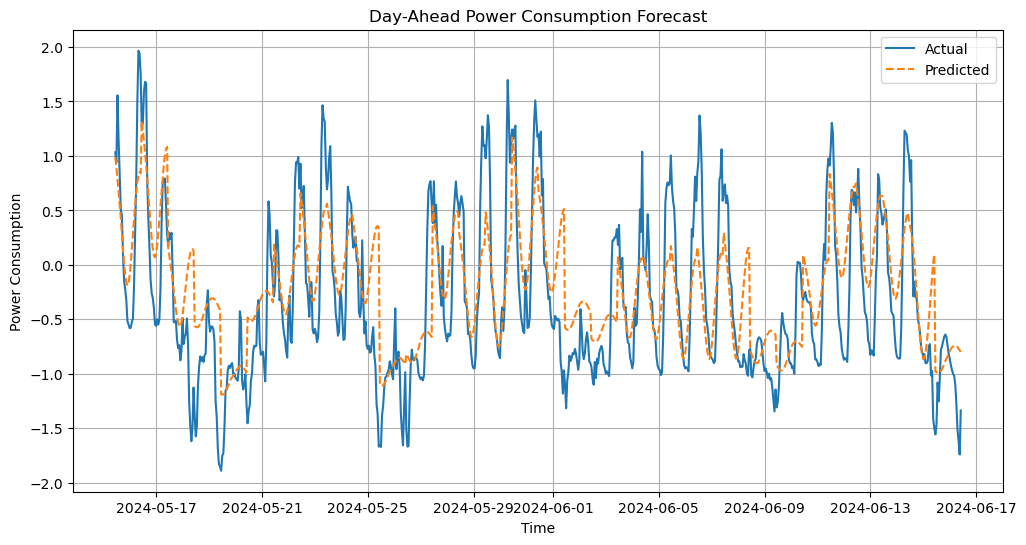

In [21]:
prediction_timestamps = [timestamps_test[0] + pd.Timedelta(hours=i) for i in np.arange(0, num_samples+forecast_horizon-1)]

predictions = day_ahead_forecast(test_predictions_np, prediction_timestamps)
actuals = day_ahead_forecast(y_test_np, prediction_timestamps)
plot_results(predictions, actuals, "Day-Ahead Power Consumption Forecast")

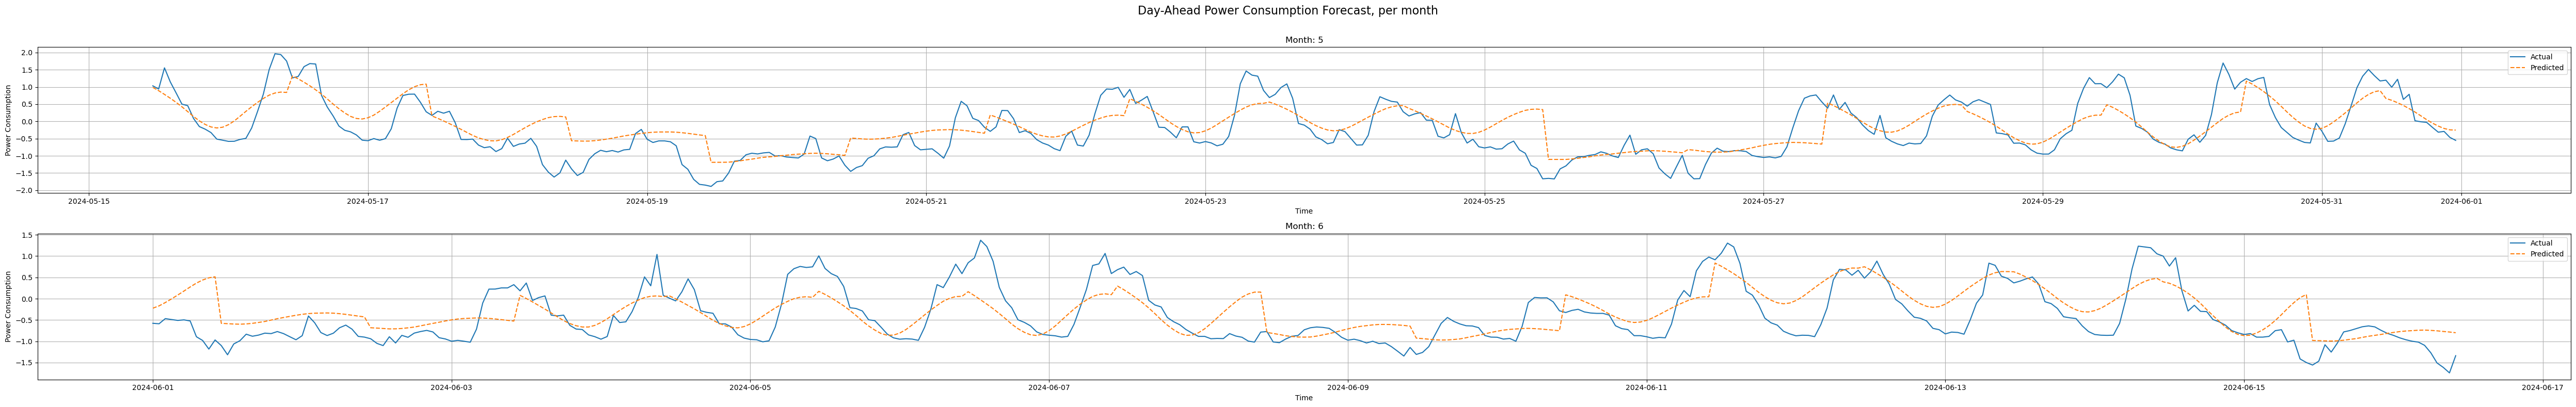

In [22]:
plot_results_by_month(predictions, actuals, "Day-Ahead Power Consumption Forecast, per month")

In [23]:
# MSE
from sklearn.metrics import mean_squared_error

# RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
    
# MAE
from sklearn.metrics import mean_absolute_error

# MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) # * 100

# ME
from sklearn.metrics import max_error

In [24]:
models = ['TCN prediction at 10 am', 'TCN predictions at all time steps']
error_dict = {'model': models,
              'RMSE': np.zeros(len(models)),
              'MAE': np.zeros(len(models)),
              'ME': np.zeros(len(models)),
              'MAPE': np.zeros(len(models))
    }
errors = pd.DataFrame(error_dict).set_index("model")

In [25]:
errors.loc[models[0], 'RMSE'] = root_mean_squared_error(actuals, predictions)
errors.loc[models[0], 'MAE'] = mean_absolute_error(actuals, predictions)
errors.loc[models[0], 'ME'] = max_error(actuals, predictions)
errors.loc[models[0], 'MAPE'] = mean_absolute_percentage_error(actuals, predictions)

In [27]:
y_pred = test_predictions.cpu().detach().numpy()  
y_true = y_test_tensor.cpu().numpy()  
errors.loc[models[1], 'RMSE'] = root_mean_squared_error(y_true.flatten(), y_pred.flatten())
errors.loc[models[1], 'MAE'] = mean_absolute_error(y_true.flatten(), y_pred.flatten())
errors.loc[models[1], 'ME'] = max_error(y_true.flatten(), y_pred.flatten())
errors.loc[models[1], 'MAPE'] = mean_absolute_percentage_error(y_true.flatten(), y_pred.flatten())
errors

,RMSE,MAE,ME,MAPE
model,,,,
TCN prediction at 10 am,0.51835,0.39840,2.01068,0.95764
TCN predictions at all time steps,0.54599,0.41095,2.06823,1.01485


In [29]:
errors / np.max(errors, axis = 0)

,RMSE,MAE,ME,MAPE
model,,,,
TCN prediction at 10 am,0.94937,0.96947,0.97217,0.94363
TCN predictions at all time steps,1.00000,1.00000,1.00000,1.00000
